# K-armed bandit
The k-armed bandit problem is a classic reinforcement learning problem where an agent has to make a series of decisions to maximize the reward it receives over time. The agent is faced with a set of $k$ actions (e.g., slot machines), each with its own unknown, stationary reward probability distribution. At each iteration, the agent chooses exactly one of the actions to play. The goal of the agent is to learn which action has the highest expected reward and to maximize the cumulative reward over time.

The k-armed bandit problem studies the trade-off between exploration and exploitation in reinforcement learning. If the agent always chooses the action with the highest observed reward so far, it may miss out on exploring other actions that could have higher rewards. On the other hand, if the agent always chooses an action at random to explore, it may waste time playing actions with lower expected rewards. The challenge is to find a balance between these two strategies that maximizes the cumulative reward over time.

## Implementation
We are given $k$ actions, each with an unknown reward distribution $R_i$. It is important that the reward distributions are stationary--the distributions remain the same between iterations. For our implementation, we define the following artificial set of $k=20$ reward distributions. Each reward distribution is a normal distribution with a different mean and standard deviation.

In [1]:
import numpy as np
from numpy import random
import matplotlib.pyplot as plt

# Means and standard deviations of the k=20 rewards' normal distributions
means = random.randint(10, size=20)
stdvs = random.randint(30, size=20)

def reward_normal_distribution(action, means=means, stdvs=stdvs):
    '''
    Returns the reward for a played action. Assumes the action's reward probability distribution is normal.
    INPUT
        action; index of the played action
        means; (k, )-shape numpy array of the means of the rewards' normal distributions
        stdvs; (k, )-shape numpy array of the standard deviations of the rewards' normal distributions
    RETURNS
        reward for action
    '''
    return random.normal(means[action], stdvs[action])

There are two types of actions the agent can take:
1. Exploit. Take the action that has so far yielded the highest average reward.
2. Explore. Take a random action to gain more samples from its reward distribution. This helps the agent learn more about the action's expected reward.

The agent is parameterized by an "exploration tendency" $0 \leq p \leq 1$, which denotes the proportion of iterations for which the agent explores. During all other iterations, the agent exploits. Each time the agent plays an action, it records the new expected reward for that action based on the reward it received.

Formally:
1. Initialize $Q \gets 0^k$, a $k$-length vector of zeros. This vector tracks the mean observed reward for each of the $k$ actions.
2. Initialize $N \gets 0^k$. This vector tracks the number of times each of the $k$ actions has been played.
3. Repeat:
    1. With probability $p$, explore: play action $a \gets \text{RANDOM}(1, ..., k)$. Otherwise, exploit: $a \gets \text{argmax}\{Q[i] | i \in \{1, ..., k\}\}$.
    2. Record the reward $R$ received for playing action $a$.
    3. $N[a] \gets N[a] + 1$
    4. $Q[a] \gets \frac{1}{N[a]} (R + (N[a] - 1) Q[a]) = Q[a] + \frac{1}{N[a]}(R - Q[a])$

In [2]:
class KArmedBandit:
    '''
    This class encapsulates a k-armed bandit problem
    '''
    # Properties from problem definition
    k = 0                       # number of possible actions
    explore_prop = 0            # proportion of iterations to explore
    reward_distribution = None  # function that returns a reward for taking one of the actions 0, ..., k-1

    # Properties from playing actions
    expected_reward = None      # tracks the observed mean reward for each action
    action_counter = None       # tracks the number of times each action has been played
    reward_tracker = []         # list tracks reward received each iteration
    
    def __init__(self, k, explore_prop, reward_distribution):
        '''
        Initializes the k-armed bandit.
        INPUT
            k; the number of actions
            explore_prop, proportion of iterations to explore
            reward_distribution; function that returns a reward for taking one of the actions 0, ..., k-1
        '''
        # Store the properties from the problem definition parameters
        self.k = k
        self.explore_prop = explore_prop
        self.reward_distribution = reward_distribution
        
        # Initialize properties from playing actions
        self.expected_reward = np.zeros(self.k) # tracks observed mean reward for each action
        self.action_counter = np.zeros(self.k)  # tracks number of times each action has been played
        self.reward_tracker = []                # tracks the reward recieved each iteration
        
    def play(self, iters=100):
        '''
        Plays iters number of iterations of the k-armed bandit.
        INPUT
            iters; number of iterations to play
        '''
        # Play iters number of iterations
        for _ in range(iters):
            
            # Decide which action to play. Explore with self.explore_prop probability; else exploit.
            action = (random.randint(self.k)
                      if random.rand() < self.explore_prop
                      else np.argmax(self.expected_reward))
            
            # Get the reward and update the observed information about the reward distributions 
            reward = self.reward_distribution(action)
            self.action_counter[action] += 1
            self.expected_reward[action] += (reward - self.expected_reward[action]) / self.action_counter[action]
            self.reward_tracker.append(reward)
            
    def plot_cumulative_reward(self):
        '''
        Creates a matplotlib.pyplot plot of the cumulative reward across the iterations.
        '''
        plt.plot(np.cumsum(self.reward_tracker), label="$p = " + str(self.explore_prop) + "$")

Let's play the k-armed bandit game using an exploration tendency of $p=0.1$.

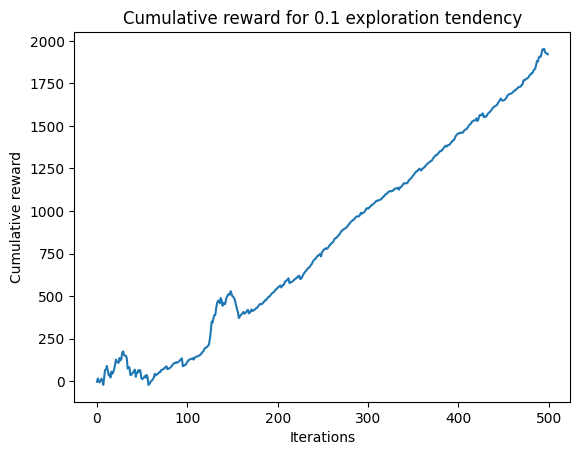

In [16]:
bandit = KArmedBandit(k=20, 
                      explore_prop=0.1, 
                      reward_distribution=reward_normal_distribution)
bandit.play(iters=500)
bandit.plot_cumulative_reward()
plt.xlabel("Iterations")
plt.ylabel("Cumulative reward")
plt.title("Cumulative reward for 0.1 exploration tendency")
plt.show()

It appears that the agent has a weak grasp of the reward distributions during the first ~300 iterations, indicated by the high volatility in reward gain. After ~300 iterations, the agent seems to have found a high-reward action, and the reward gain is much smoother after this point.

The k-armed bandit model is highly sensitive to the exploration tendency $p$ parameter. Let's test what happens if we use different values for $p$.

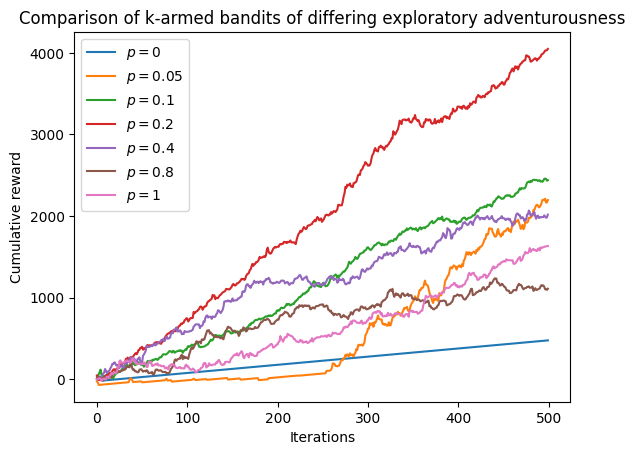

In [18]:
# Define list of p values to test
exploration_prop_list = [0, 0.05, 0.1, 0.2, 0.4, 0.8, 1]

# Make a list of bandits
gang = [KArmedBandit(k=20, explore_prop=prop, reward_distribution=reward_normal_distribution)
            for prop in exploration_prop_list]

# Test the bandits
for bandit in gang:
    bandit.play(iters=500)
    bandit.plot_cumulative_reward()
    
# Plot    
plt.xlabel("Iterations")
plt.ylabel("Cumulative reward")
plt.title("Comparison of k-armed bandits of differing exploratory adventurousness")
plt.legend()
plt.show()

The $p=0.2$ agent appears most successful. This illustrates the explore/exploit tradeoff. The $p=0$ agent only exploits, so they "lock into" repeating a suboptimal action. The $p=1$ agent always explores, so their reward gain is equivalent to playing actions at random. The right balance is required to achieve maximum reward.